In [184]:
import numpy as np
import matplotlib.pyplot as plt
#TODO: - tune epsilon?
#      - what is C and A?
#      - leap-frog in SG methods?
#      - fisher information in SGLD?

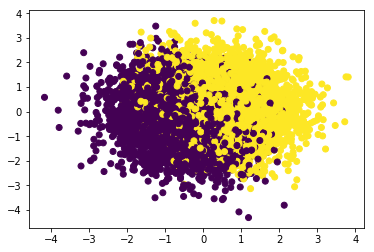

In [137]:
data = np.load("./mcs_hw2_p3_data.npy")
X = data[:, :2]
Y = data[:, -1]
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [13]:
def logit(x):
    return 1 / (1 + np.exp(-x))

In [171]:
def potential_energy(beta, X, Y):
    likelihood_prior = -0.5 * np.sum(beta ** 2)
    likelihood_data = Y.T @ X @ beta - np.sum(np.log(1 + np.exp(X @ beta)))
    return -likelihood_prior - likelihood_data

In [172]:
def grad_potential_energy(beta, X, Y):
    Y_pred = logit(X @ beta)
    diff = Y - Y_pred
    grad = X.T @ diff / X.shape[0] * data.shape[0] + beta
    return -grad

In [153]:
def hmc(beta, X, Y, num_step, epsilon, sample_step = False):
    beta_backup = beta.copy()
    momentum = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]])
    #print(momentum)
    energy_initial = potential_energy(beta, X, Y) + 0.5 * momentum.T @ momentum
    #print(energy_initial, beta)
    if sample_step:
        num_step = np.random.randint(0, num_step)
    for i in range(num_step):
        momentum -= epsilon / 2 * grad_potential_energy(beta, X, Y)
        beta += epsilon * momentum
        momentum -= epsilon / 2 * grad_potential_energy(beta, X, Y)
        #print(momentum, beta)
    energy_final = potential_energy(beta, X, Y) + 0.5 * momentum.T @ momentum
    #print(energy_final)
    if np.random.uniform() < np.min((1.0, np.exp(energy_initial - energy_final))):
        return beta
    else:
        return beta_backup

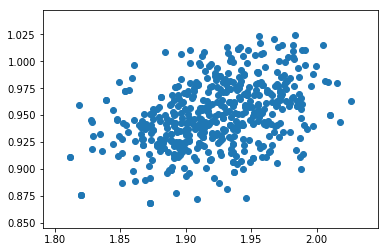

In [154]:
beta = np.array([0.0, 0.0])
res_beta = []
for i in range(1000):
    beta = hmc(beta, X, Y, 5, 0.01)
    res_beta.append(list(beta))

res_beta = np.array(res_beta)

plt.scatter(res_beta[500:, 0], res_beta[500:, 1])

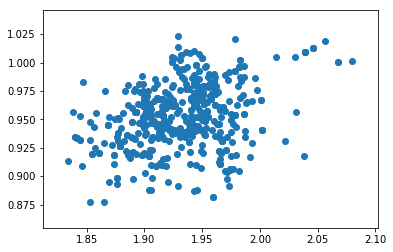

In [155]:
beta = np.array([0.0, 0.0])
res_beta = []
for i in range(1000):
    beta = hmc(beta, X, Y, 5, 0.01, True)
    res_beta.append(list(beta))

res_beta = np.array(res_beta)

plt.scatter(res_beta[500:, 0], res_beta[500:, 1])

In [173]:
def get_batch(X, Y, batch_size):
    n = X.shape[0]
    start_ele = np.random.randint(0, n)
    if start_ele + batch_size >= n:
        X_batch = np.concatenate((X[start_ele: ], X[ :start_ele + batch_size - n]))
        Y_batch = np.concatenate((Y[start_ele: ], Y[ :start_ele + batch_size - n]))
    else:
        X_batch = X[start_ele: (start_ele + batch_size)]
        Y_batch = Y[start_ele: (start_ele + batch_size)]
    return X_batch, Y_batch

In [174]:
def sgld(beta, X, Y, num_step, epsilon, batch_size):
    momentum = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]])
    noise = np.random.multivariate_normal([0, 0], [[epsilon, 0], [0, epsilon]])
    for i in range(num_step):
        X_b, Y_b = get_batch(X, Y, batch_size)
        momentum -= epsilon / 2 * grad_potential_energy(beta, X_b, Y_b) + noise
        beta += epsilon * momentum
        momentum -= epsilon / 2 * grad_potential_energy(beta, X_b, Y_b) + noise
    return beta

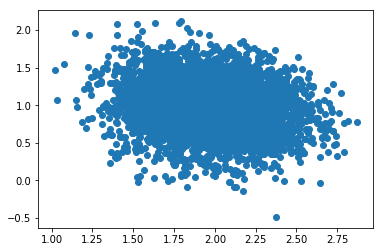

In [203]:
beta = np.array([0.0, 0.0])
res_beta = []
for i in range(10000):
    beta = sgld(beta, X, Y, 5, 0.01, 32)
    res_beta.append(list(beta))

res_beta = np.array(res_beta)

#print(np.mean(res_beta[5000:, :], axis = 0))

plt.scatter(res_beta[5000:, 0], res_beta[5000:, 1])

In [199]:
def sghmc(beta, X, Y, num_step, epsilon, batch_size):
    # what is C?
    momentum = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]])
    noise = np.random.multivariate_normal([0, 0], [[epsilon, 0], [0, epsilon]])
    for i in range(num_step):
        X_b, Y_b = get_batch(X, Y, batch_size)
        momentum -= epsilon / 2 * grad_potential_energy(beta, X_b, Y_b) + epsilon / 2 * momentum + noise
        beta += epsilon * momentum
        momentum -= epsilon / 2 * grad_potential_energy(beta, X_b, Y_b) + epsilon / 2 * momentum + noise
    return beta

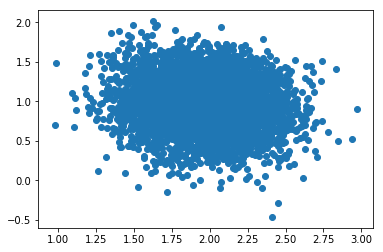

In [204]:
beta = np.array([0.0, 0.0])
res_beta = []
for i in range(10000):
    beta = sghmc(beta, X, Y, 5, 0.01, 32)
    res_beta.append(list(beta))

res_beta = np.array(res_beta)

#print(np.mean(res_beta[5000:, :], axis = 0))

plt.scatter(res_beta[5000:, 0], res_beta[5000:, 1])